# Library

In [1]:
import os
import xml.etree.ElementTree as ET
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

from sklearn import preprocessing

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

from IPython.display import clear_output

torch.manual_seed(2002)
np.random.seed(2002)
random.seed(2002)

import time
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

# Load data

In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2024-05-18 02:04:51--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  24.5MB/s    in 85s     

2024-05-18 02:06:17 (22.4 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [3]:
!ls VOCdevkit/VOC2012/

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [4]:
!pip install pillow

In [5]:
base_dir = 'VOCdevkit/VOC2012/'
annotations_dir = os.path.join(base_dir, 'Annotations')
image_dir = os.path.join(base_dir, 'JPEGImages')
xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir)]

In [6]:
class XmlParser:
    def __init__(self, xml_file, img_path):
        self.xml_file = xml_file
        self.img_path = img_path
        self._root = self.parse_xml()
        self._objects = self._root.findall("object")
        self.image_id = self._root.find("filename").text
        self.names, self.boxes, self.sizes = self.extract_data()

    def parse_xml(self):
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def extract_data(self):
        names = []
        boxes = []
        size_element = self._root.find("size")
        width = int(size_element.find("width").text)
        height = int(size_element.find("height").text)
        sizes = np.array([width, height])

        for obj in self._objects:
            name = obj.find("name").text
            names.append(name)

            bndbox = obj.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymin = int(float(bndbox.find("ymin").text))
            ymax = int(float(bndbox.find("ymax").text))
            coordinates = np.array([xmin, xmax, ymin, ymax])
            boxes.append(coordinates)

        return np.array(names), np.array(boxes), sizes

In [7]:
def xml_files_to_df(xml_files, img_path):
    data = []
    for xml_file in xml_files:
        parser = XmlParser(xml_file, img_path)
        for name, box in zip(parser.names, parser.boxes):
            data.append({
                'xml_file': parser.xml_file,
                'image_id': parser.image_id,
                'img_path': parser.img_path,
                'name': name,
                "boxes": box,
                'xmin': box[0],
                'xmax': box[1],
                'ymin': box[2],
                'ymax': box[3],
                'width': parser.sizes[0],
                'height': parser.sizes[1]
            })
    df = pd.DataFrame(data)
    return df

In [8]:
df = xml_files_to_df(xml_files, image_dir)
df = df.sort_values(by=['image_id']).reset_index().drop(columns='index')
df

,xml_file,image_id,img_path,name,boxes,xmin,xmax,ymin,ymax,width,height
0,VOCdevkit/VOC2012/Annotations/2007_000027.xml,2007_000027.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[174, 349, 101, 351]",174,349,101,351,486,500
1,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[26, 44, 189, 238]",26,44,189,238,500,281
2,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,aeroplane,"[104, 375, 78, 183]",104,375,78,183,500,281
3,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,aeroplane,"[133, 197, 88, 123]",133,197,88,123,500,281
4,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[195, 213, 180, 229]",195,213,180,229,500,281
...,...,...,...,...,...,...,...,...,...,...,...
40133,VOCdevkit/VOC2012/Annotations/2012_004328.xml,2012_004328.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[59, 166, 220, 415]",59,166,220,415,328,500
40134,VOCdevkit/VOC2012/Annotations/2012_004328.xml,2012_004328.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[219, 268, 226, 332]",219,268,226,332,328,500
40135,VOCdevkit/VOC2012/Annotations/2012_004329.xml,2012_004329.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[57, 284, 88, 397]",57,284,88,397,333,500
40136,VOCdevkit/VOC2012/Annotations/2012_004330.xml,2012_004330.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[230, 370, 133, 441]",230,370,133,441,375,500


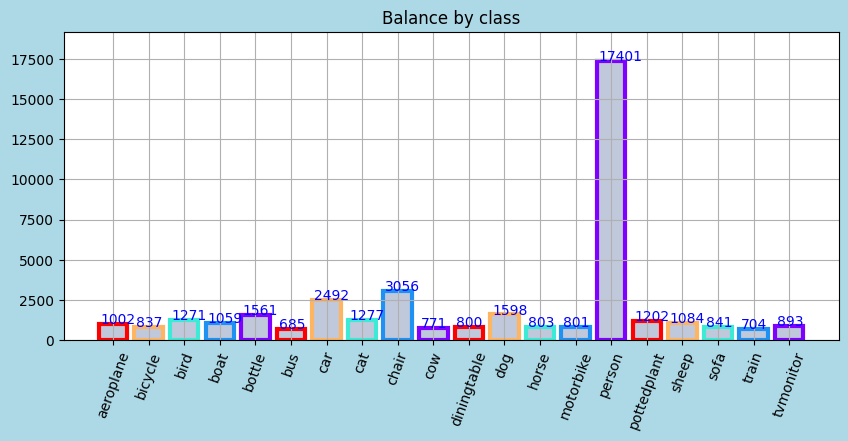

In [9]:
grp_class = df.groupby('name')['xmin'].count()

grp_class = df.groupby('name').count()['xmin']
colors = ['#FF0000','#FEB562','#3DEAD5','#1E91F3','#8000FF']
fig, ax = plt.subplots(figsize=(10,4), facecolor='lightblue')

ax.bar(grp_class.index, grp_class, color='#C0C8DB', linewidth=3.0, edgecolor=colors)
for i in range(len(df['name'].unique())):
    ax.text(i-0.35, grp_class.iloc[i]+1, grp_class.iloc[i], color='#0000FF') # +70 all records
plt.xticks(rotation=70)
ax.set_ylim(0, grp_class.max()+round(grp_class.max()/np.log(grp_class.max()), 2))
plt.grid(True)
ax.set_title("Balance by class")
plt.show();

In [10]:
labels = {v: (idx+1) for idx, v in enumerate(sorted(df['name'].unique()))}
df['labels'] = df['name'].replace(labels)
df['labels'] = df['labels'].astype('int')

In [11]:
df

,xml_file,image_id,img_path,name,boxes,xmin,xmax,ymin,ymax,width,height,labels
0,VOCdevkit/VOC2012/Annotations/2007_000027.xml,2007_000027.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[174, 349, 101, 351]",174,349,101,351,486,500,15
1,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[26, 44, 189, 238]",26,44,189,238,500,281,15
2,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,aeroplane,"[104, 375, 78, 183]",104,375,78,183,500,281,1
3,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,aeroplane,"[133, 197, 88, 123]",133,197,88,123,500,281,1
4,VOCdevkit/VOC2012/Annotations/2007_000032.xml,2007_000032.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[195, 213, 180, 229]",195,213,180,229,500,281,15
...,...,...,...,...,...,...,...,...,...,...,...,...
40133,VOCdevkit/VOC2012/Annotations/2012_004328.xml,2012_004328.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[59, 166, 220, 415]",59,166,220,415,328,500,15
40134,VOCdevkit/VOC2012/Annotations/2012_004328.xml,2012_004328.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[219, 268, 226, 332]",219,268,226,332,328,500,15
40135,VOCdevkit/VOC2012/Annotations/2012_004329.xml,2012_004329.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[57, 284, 88, 397]",57,284,88,397,333,500,15
40136,VOCdevkit/VOC2012/Annotations/2012_004330.xml,2012_004330.jpg,VOCdevkit/VOC2012/JPEGImages,person,"[230, 370, 133, 441]",230,370,133,441,375,500,15


In [12]:
df[['name','labels']].value_counts()

name         labels
person       15        17401
chair        9          3056
car          7          2492
dog          12         1598
bottle       5          1561
cat          8          1277
bird         3          1271
pottedplant  16         1202
sheep        17         1084
boat         4          1059
aeroplane    1          1002
tvmonitor    20          893
sofa         18          841
bicycle      2           837
horse        13          803
motorbike    14          801
diningtable  11          800
cow          10          771
train        19          704
bus          6           685
Name: count, dtype: int64

In [13]:
classes= {1:'aeroplane',2:'bicycle',3:'bird',4:'boat',5:'bottle',6:'bus',7:'car',8:'cat',9:'chair',10:'cow',11:'diningtable',12:'dog',13:'horse',14:'motorbike',15:'person',16:'pottedplant',17:'sheep',18:'sofa',19:'train',20:'tvmonitor'}

In [14]:
df.drop(columns=['name'], inplace=True)

In [15]:
image_ids = df['image_id'].unique()
image_ids

array(['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', ...,
       '2012_004329.jpg', '2012_004330.jpg', '2012_004331.jpg'],
      dtype=object)

In [16]:
num_samples = len(df)
num_train = int(0.08 * num_samples)
num_valid = int(0.015 * num_samples)
num_test = num_samples - num_train - num_valid

train_df = df[:num_train]
valid_df = df[num_train:num_train+num_valid]
test_df = df[num_train+num_test:]

print("train:", len(train_df))
print("validation:", len(valid_df))
print("test:", len(test_df))

train: 3211
validation: 602
test: 602


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class VOCDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image_path = f'{self.image_dir}/{image_id}'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if image is None:
           raise FileNotFoundError(f'Image not found at path: {image_path}')

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        label = records['labels'].values
        labels = torch.as_tensor(label, dtype=torch.int64)

        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms:
          sample = {
              'image': image,
              'bboxes': target['boxes'],
              'labels': labels
          }
          sample = self.transforms(**sample)
          image = sample['image']

          target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)

        return image, target


    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [19]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height=512, width=512),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_transform_valid():
    return A.Compose([
        A.Resize(height=512, width=512),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_transform_test():
    return A.Compose([
        A.Resize(height=512, width=512),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_df, image_dir , get_transform_train())
valid_dataset = VOCDataset(valid_df, image_dir , get_transform_valid())
test_dataset = VOCDataset(test_df, image_dir, get_transform_test())


indices = torch.randperm(len(train_dataset)).tolist()


train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

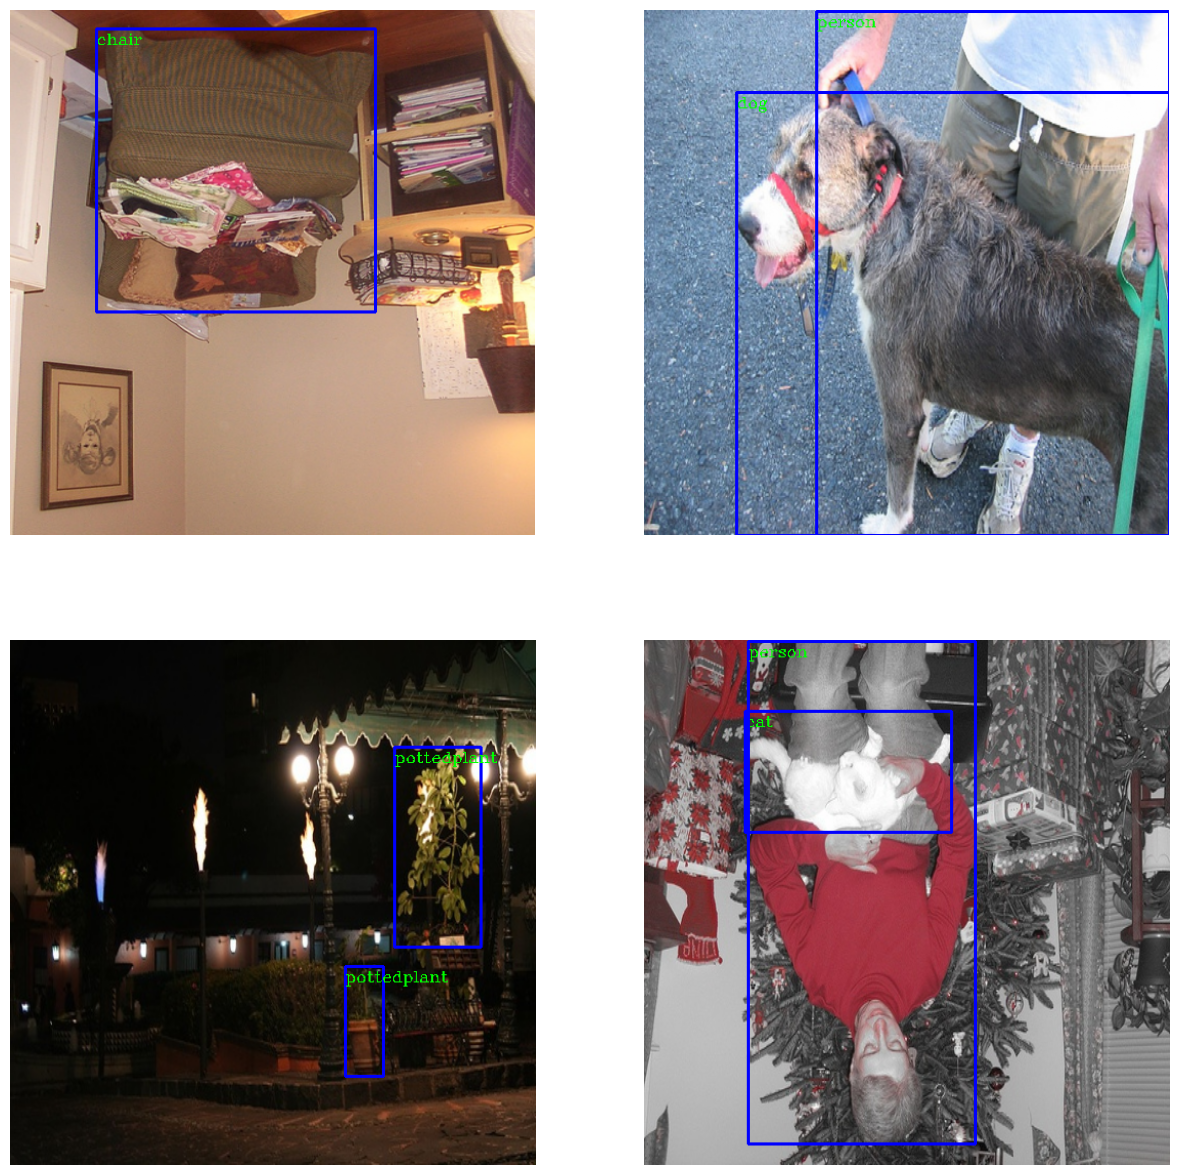

In [21]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

plt.figure(figsize=(15,15))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

# Faster R-CNN

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = len(classes)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
print(f'\nDevice: {device}, number of classes: {num_classes}, pretrained model: Resnet-50')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 82.9MB/s]



Device: cuda, number of classes: 20, pretrained model: Resnet-50


In [23]:
def calc(model, optimizer, dataloader, scheduler):
    scheduler = scheduler
    model.train()
    def sub_calc(dataloader, scheduler, is_train=True, mode='train'):
        loss, indx = [], 0
        torch.set_grad_enabled(is_train)

        for i, (images, targets) in tqdm(enumerate(dataloader)):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss.append(losses.item())
            if is_train:
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
        scheduler.step() if is_train else scheduler
        return round(np.mean(loss), 4)
    return sub_calc(train_data_loader, scheduler, True, 'train'), sub_calc(valid_data_loader, scheduler, False, 'valid')

In [24]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.7, weight_decay=0.0005)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0003, max_lr=0.01,step_size_up=5,mode="exp_range",gamma=0.85)

In [25]:
num_epochs = 10
total_train_loss = []
total_valid_loss = []
total_epochs = []
best_model = 1000
start = datetime.now()
for epoch in range(num_epochs):
    print(f'There is a calculation of {epoch+1} epoch out of {num_epochs}.\
    Please wait...', end='\r')
    train_loss, valid_loss = calc(model, optimizer, train_data_loader, scheduler)
    total_train_loss.append(train_loss)
    total_valid_loss.append(valid_loss)
    total_epochs.append(epoch+1)
    if valid_loss < best_model:
        best_model = valid_loss
        path_best = f"ep{str(epoch+1)}_best_model.pth"
        torch.save(model.state_dict(), path_best)
    clear_output(wait=True)
    print('')
end = datetime.now()
print("Runtime Faster RCNN:",str(end-start)[:7])


Runtime Faster RCNN: 0:40:52


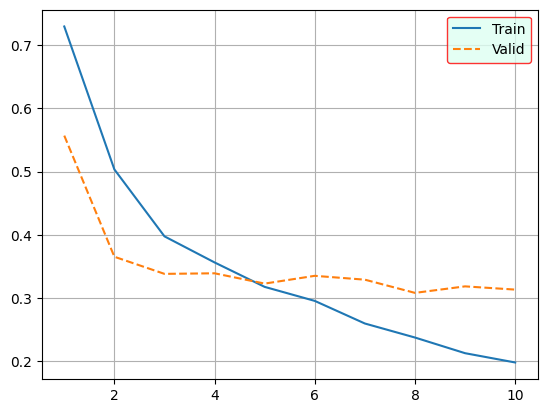

In [26]:
plt.plot(total_epochs, total_train_loss, label='Train')
plt.plot(total_epochs, total_valid_loss, label='Valid', linestyle='--')
plt.grid(True)
plt.legend(loc=1, frameon=True, edgecolor='red', facecolor='#DEFFF2')
plt.show();

In [27]:
from torchvision.ops import box_iou

def calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels):
    average_precisions = torch.zeros(len(classes))

    for c in range(len(classes)):
        class_pred_boxes = pred_boxes[pred_labels == c]
        class_pred_scores = pred_scores[pred_labels == c]
        class_true_boxes = true_boxes[true_labels == c]

        if class_pred_boxes.numel() == 0 or class_true_boxes.numel() == 0:
            continue

        sort_idx = torch.argsort(class_pred_scores, descending=True)
        class_pred_boxes = class_pred_boxes[sort_idx]

        ious = box_iou(class_pred_boxes, class_true_boxes)

        tp = torch.zeros(class_pred_boxes.size(0))
        fp = torch.zeros(class_pred_boxes.size(0))

        for i in range(class_pred_boxes.size(0)):
            max_iou, max_idx = ious[i].max(0)

            if max_iou >= 0.5:
                tp[i] = 1
                ious[:, max_idx] = 0
            else:
                fp[i] = 1

        tp_cumsum = torch.cumsum(tp, dim=0)
        fp_cumsum = torch.cumsum(fp, dim=0)

        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
        recall = tp_cumsum / class_true_boxes.size(0)

        average_precision = torch.sum((recall[1:] - recall[:-1]) * precision[1:])
        average_precisions[c] = average_precision

    mAP = average_precisions.mean().item()

    return mAP

In [36]:
model.eval()
with torch.no_grad():
    for i, (images, targets) in enumerate(test_data_loader):
        images = [image.to(device) for image in images]

        if isinstance(targets, dict):
            targets = {k: v.to(device) for k, v in targets.items()}
        else:
            continue

        pred_scores, pred_labels, pred_boxes = model(images)

        for j in range(len(images)):
            print(f'Sample {i * test_data_loader.batch_size + j + 1}:')
            print('Predicted Scores:', pred_scores[j])
            print('Predicted Labels:', pred_labels[j])
            print('Predicted Boxes:', pred_boxes[j])

        true_boxes = targets['boxes']
        true_labels = targets['labels']

        mAP = calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels)
        print(f'Iteration: {i}, mAP: {mAP}')

Em không biết sao nó không chạy ra được mAP huhu

In [76]:
model.eval()

total_correct_predictions = 0
total_predictions = 0

for images, targets in test_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images)

    for pred, target in zip(prediction, targets):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        true_boxes = target['boxes']
        true_labels = target['labels']

    if pred_boxes.shape[0] != true_boxes.shape[0]:
        continue

    iou = torchvision.ops.box_iou(pred_boxes, true_boxes)

    if pred_labels.shape[0] != true_labels.shape[0]:
        continue

    correct_predictions = (iou > 0.5) & (pred_labels[:, None] == true_labels)

    total_correct_predictions += torch.sum(correct_predictions).item()
    total_predictions += len(pred_boxes)

mean_accuracy = total_correct_predictions / total_predictions
print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 1.0
